In [1]:
# -*- coding: utf-8 -*-

# Created on Mon Feb  8 14:05:10 2021

# @author: shossein



In [2]:
#%%
#!pip install PyPDF2

In [3]:
#pip install scipy==1.2 --upgrade

In [4]:
#pip install statsmodels --upgrade 

In [1]:
#%%
# Next we want to install all packages and libraries we need for our analysis

from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import os.path

import pandas as pd
import pyabf
import numpy as np
import matplotlib.pyplot as plt
import pyabf.tools
import chart_studio.plotly as py
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

C:\Users\shossein\Anaconda3\lib\site-packages\pyabf\tools\__init__.py:8: UserWarning: All pyabf.tools modules are experimental (APIs may change)
  warnings.warn("All pyabf.tools modules are experimental (APIs may change)")


In [289]:
#%% Series Resistance (Rs) /  Membrane resistance (Rm) /Whole cell capacitance (Cp)
''' hhh '''
# a trace with a test pulse
path = r'C:\Users\shossein\Desktop\New folder\2020\December\14.12.2020'
save_path = r'C:\Users\shossein\Desktop\New folder\2020\December\14.12.2020\Cell_7\Intrinsic_properties' # DEFINE the file directory for saving
abf = pyabf.ABF(path + '\THC_1261_PFC_Cronos_14122020_0046.abf')
#Take alook at the data
print(abf)


# Long-Square I-V traces
abfIV = pyabf.ABF(path + '\THC_1261_PFC_Cronos_14122020_0041.abf')

print(abfIV)

ABF (version 2.9.0.0) with 3 channels (pA, mV, V), sampled at 20.0 kHz, containing 6 sweeps, having no tags, with a total length of 3.73 minutes, recorded with protocol "VC_TP_5s_PP_ChB200ms_5s".
ABF (version 2.9.0.0) with 2 channels (mV, mV), sampled at 20.0 kHz, containing 16 sweeps, having no tags, with a total length of 0.26 minutes, recorded with protocol "CC_longSquare_IV_ABA".


In [290]:
#%% Fitteing a single exponential to to the current transient
# b is the slope or the time constant in ms; C is the itercept or the steady state current and a is peak current 

def func_exp_1(x, a, b, c):
   return a * np.exp(-x/b) -c # If multiplication the devide by 1


In [291]:
#%% get the voltage step which was applied during test pulse
sr = abf.dataRate   # SAMPLING rate in Hz
srIV = abfIV.dataRate
start = np.int(0 * sr) # start of baseline
end = np.int(0.5 * sr ) # end of baseline
start1 = np.int(1.01 * sr) # start of voltage step
end1 = np.int(1.02 * sr ) # end of voltage step

voltage_step = []
for i in range (0,3): # the number of sweeps in hyperpolarization steps
    abf.setSweep(sweepNumber=i, channel=1)
    voltage_step.append(np.mean(abf.sweepY[start1:end1]) - np.mean(abf.sweepY[start:end]))
voltage_step = np.abs(np.mean(voltage_step))
print(voltage_step)

5.01178


0.0022563934


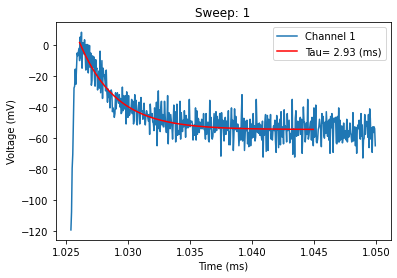

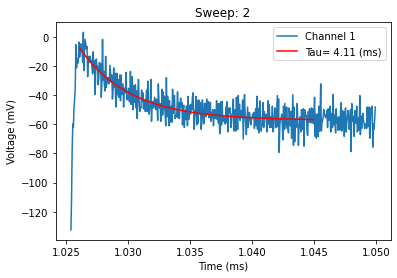

In [302]:
#%% get the voltage step which was applied during test pulse
sr = abf.dataRate   # SAMPLING rate in Hz
start = np.int(0 * sr) # start of baseline
end = np.int(0.5 * sr ) # end of baseline
start1 = np.int(0.6 * sr) # start of voltage step
end1 = np.int(0.61 * sr ) # end of voltage step

voltage_step = []
for i in range (1,3): # the number of sweeps in hyperpolarization steps
    abf.setSweep(sweepNumber=i, channel=1)
    voltage_step.append(np.mean(abf.sweepY[start1:end1]) - np.mean(abf.sweepY[start:end]))
voltage_step = np.abs(np.mean(voltage_step))
print(voltage_step)

#%% Leak current (pA) / Series Resistance (Rs) /  Membrane resistance (Rm) /Whole cell capacitance (Cp)
#Defining the window for the single exponential curve fit
start = np.int(1.0261 * sr) # start point of the exponential fit 
end = np.int(1.045 * sr ) #  end point of the exponential fit 
start1 = np.int(1.0254 * sr) # start point of the display 
end1 = np.int(1.05 * sr ) # end point of the display 

tau_test =[]
series_resitance = []
membrane_resitance_test = []
leak_current = []
Whole_Cell_Capacitance =[]
for i in range (1,3): # the number of sweeps in hyperpolarization steps
    abf.setSweep(sweepNumber=i, channel=0)
    fig1 = plt.figure()
    plt.plot(abf.sweepX[start1:end1], abf.sweepY[start1:end1], label="Channel 1")
    p0= [max(abf.sweepY[start:end]),0.5,min(abf.sweepY[start:end])]
    # plt.plot(abf.sweepX[start1:end1], smooth(abf.sweepY,smooth_win)[start1:end1], 'g-') 
    popt, pcov = curve_fit(func_exp_1, abf.sweepX[start:end], abf.sweepY[start:end], p0, maxfev = 100000)
    

    plt.plot(abf.sweepX[start:end], func_exp_1(abf.sweepX[start:end], *popt), 'r-',
    label='Tau=%5.2f (ms)' % ((popt[1]*1e3)))
    series_resitance_a = voltage_step/np.log(popt[0])*1e6 # should be - (negetive if the curve is going down)and 3x the pipette opening resistance
    series_resitance.append(voltage_step/np.log(popt[0])*1e6) # should be - (negetive if the curve is going down); the unit is in MegaOhm
    leak_current_a = -popt[2]
    leak_current.append(popt[2])
    membrane_resitance_a = ((voltage_step / leak_current_a)*1e6 - series_resitance_a)
    membrane_resitance_test.append(((voltage_step / leak_current_a)*1e6 - series_resitance_a)) # the unit is in MegaOhm
    Whole_Cell_Capacitance.append(((popt[1]*1e3)) * ((1 / series_resitance_a) + (1/ membrane_resitance_a))*1e2)
    tau_test.append((popt[1]*1e3))
    plt.title('Sweep: %d' %i)
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
plt.savefig(os.path.join(save_path , 'Test_pulse_Fit.pdf'))
plt.savefig(os.path.join(save_path , 'Test_pulse_Fit.svg'))

tau_test = np.mean(tau_test)
series_resitance = np.mean(series_resitance)
membrane_resitance_test = np.mean(membrane_resitance_test)
leak_current = np.mean(leak_current)
Whole_Cell_Capacitance =np.mean(Whole_Cell_Capacitance)

In [305]:
membrane_resitance_test

-48.14678446467994

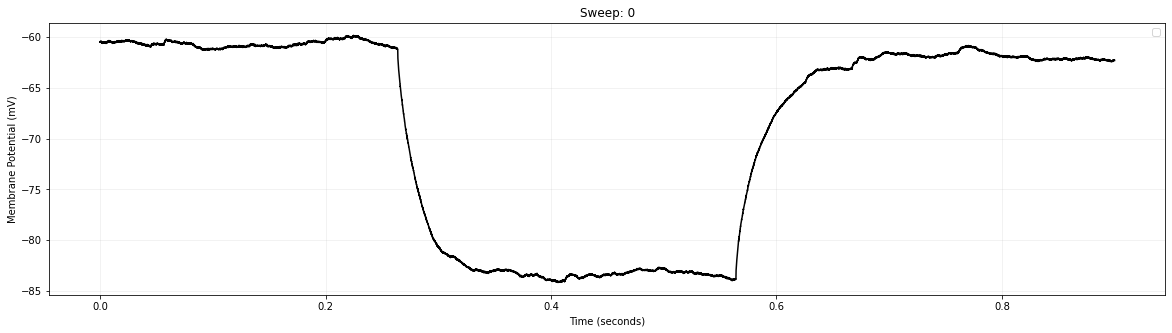

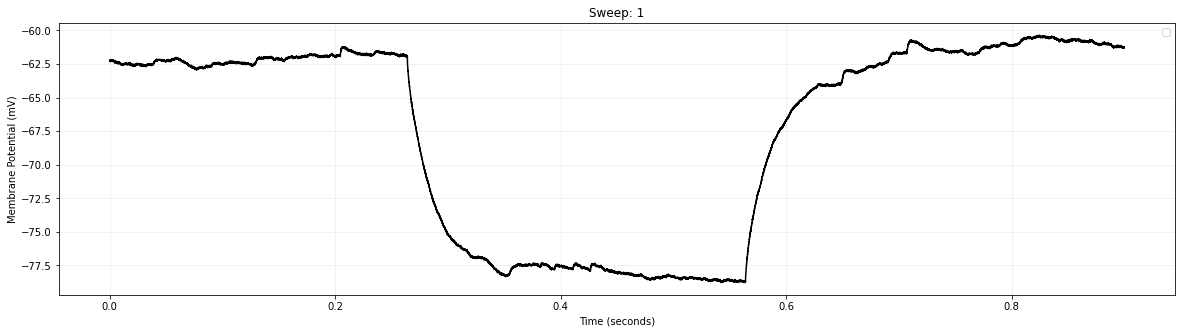

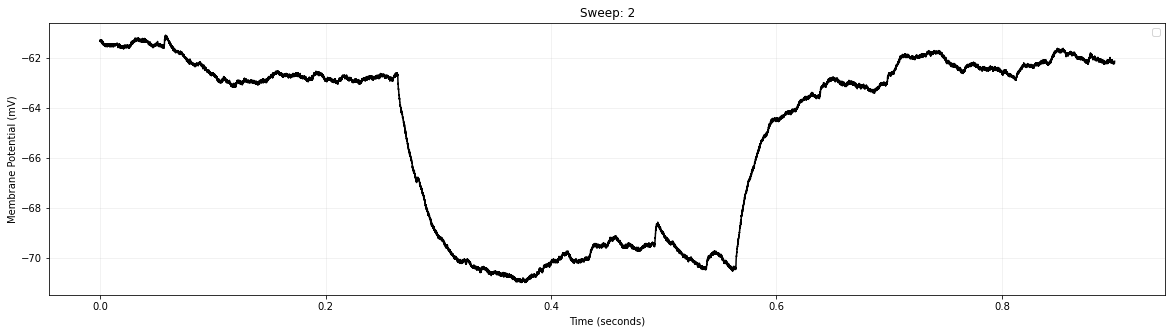

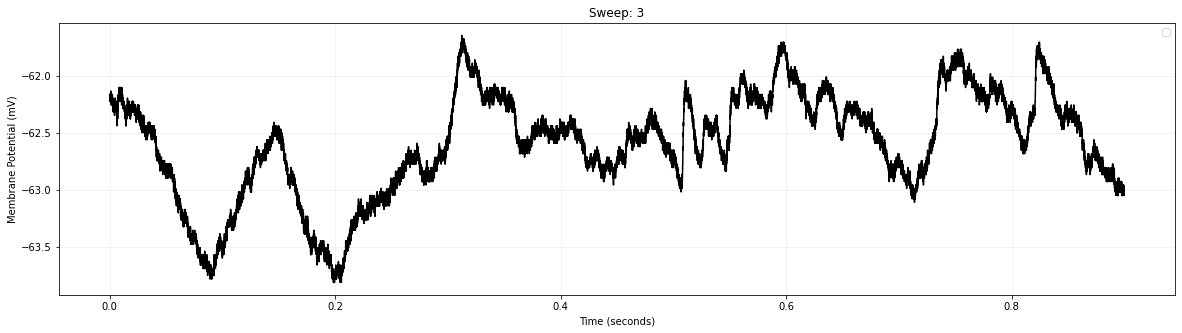

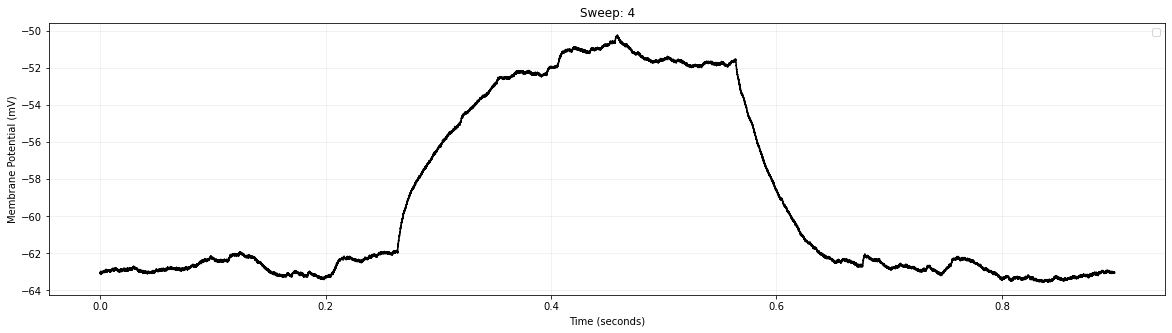

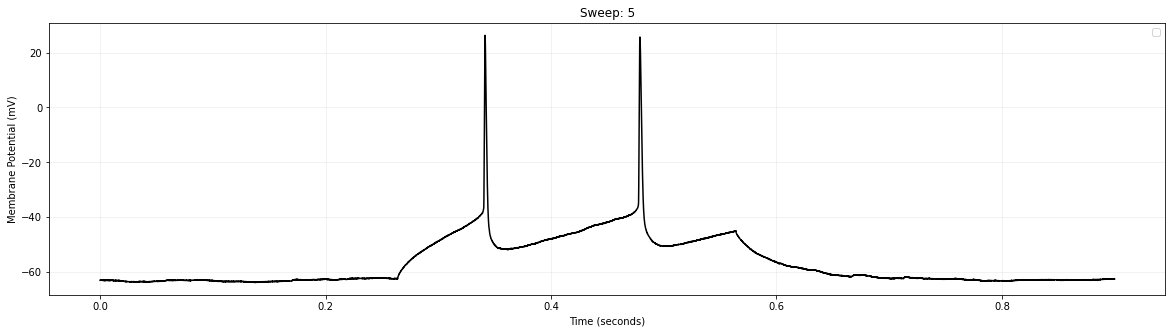

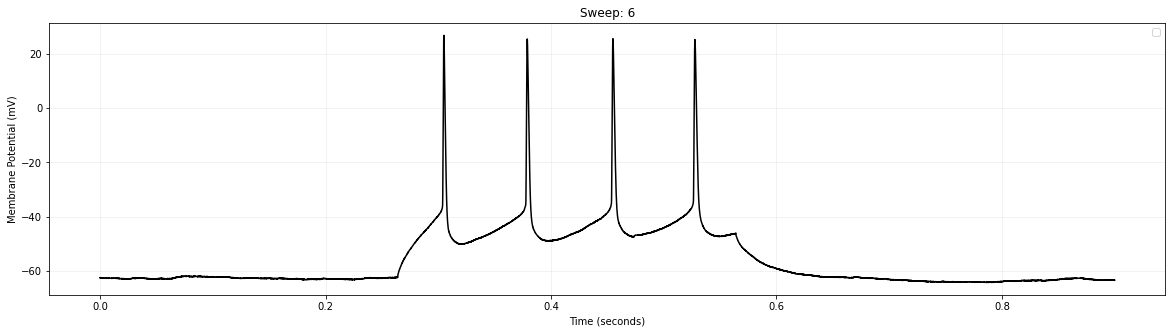

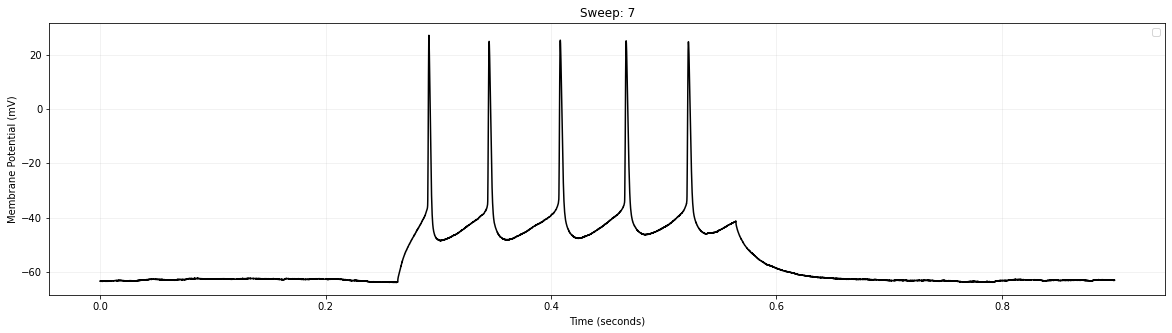

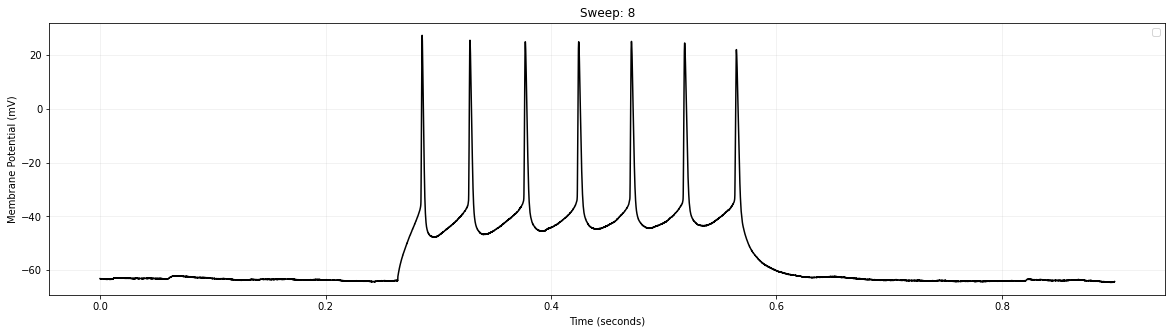

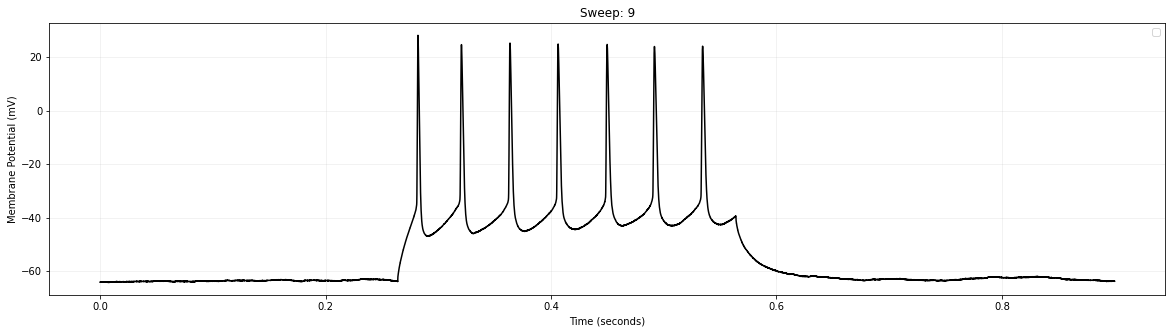

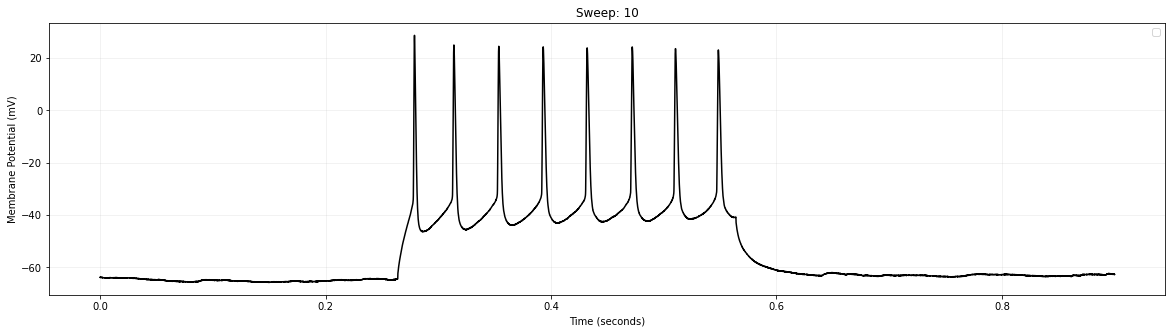

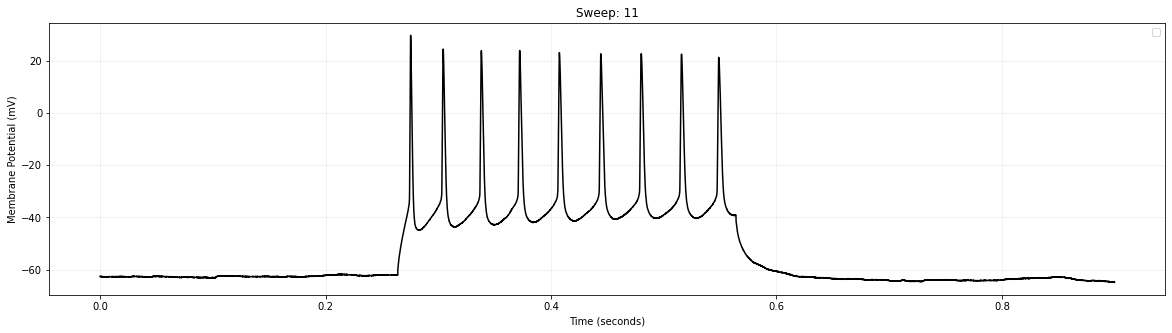

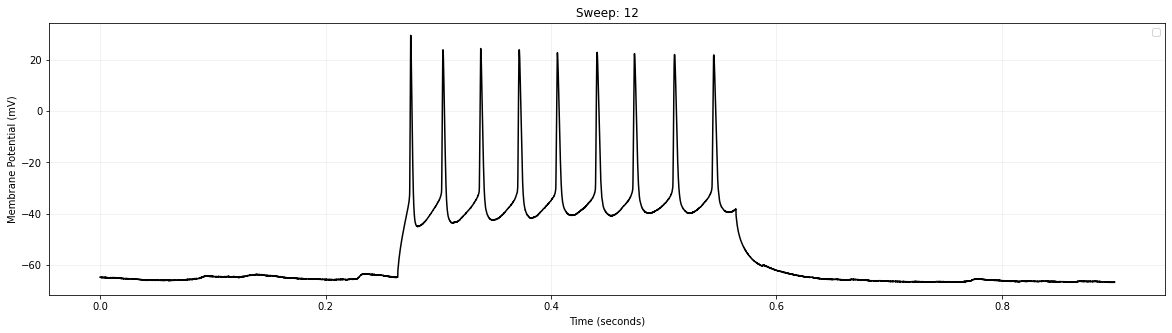

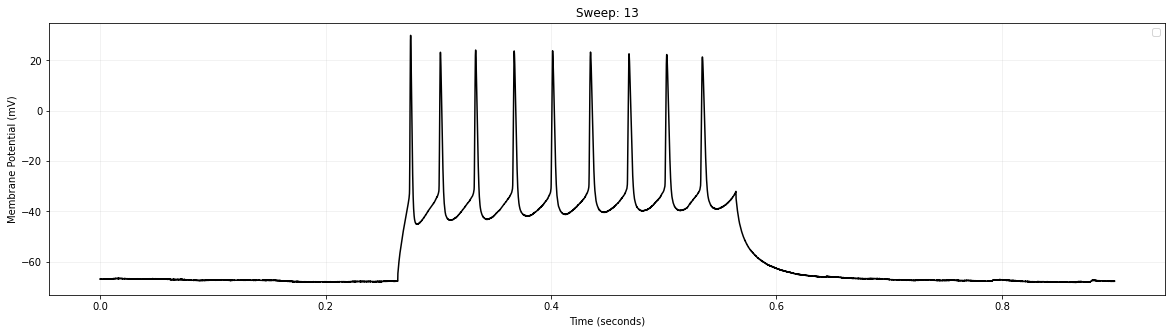

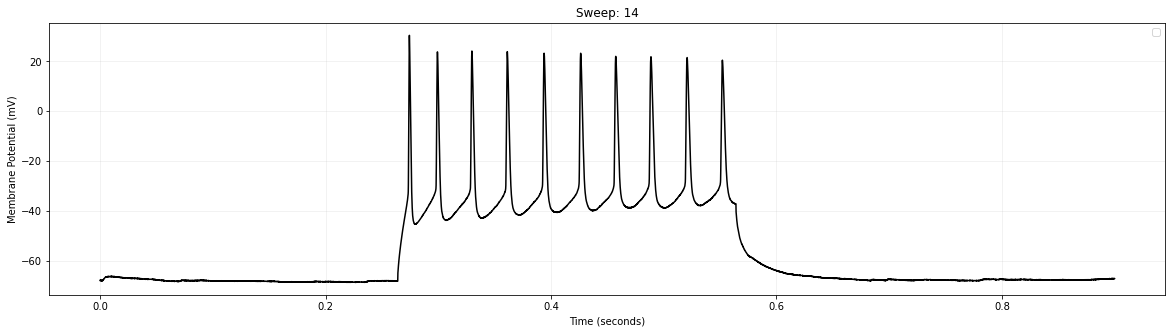

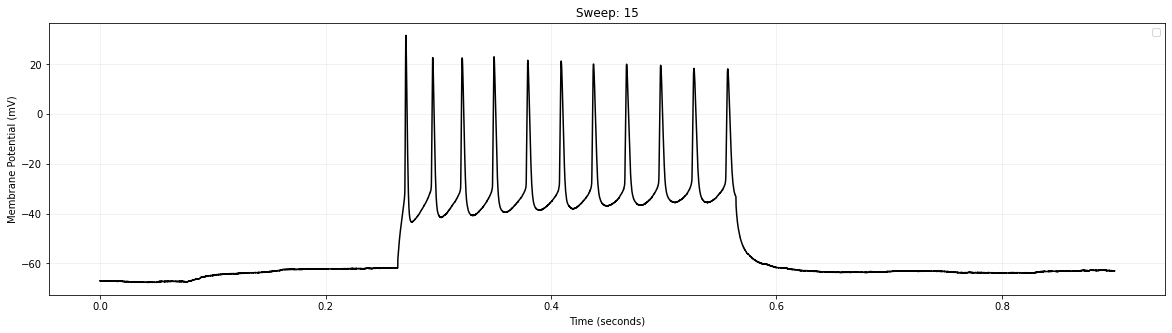

In [306]:
#%%
# Taking look at the sweeps
for i in range(abfIV.sweepCount):
    abfIV.setSweep(i)
    plt.figure(figsize=(20, 5))
    plt.legend("i")
    # decorate the plots
    plt.title('Sweep: %d' %i)
    plt.ylabel(abfIV.sweepLabelY)
    plt.xlabel(abfIV.sweepLabelX)
    plt.grid(alpha=.2)
    

    plt.plot(abfIV.sweepX, abfIV.sweepY, color="k")

In [154]:
#%% Get the current steps in current clamp protocol
# 10% OF Of THE TRACE (get these start and end valuse from pClamp)
sr = abfIV.dataRate   # SAMPLING rate in Hz
start = np.int(0.550 * sr) 
end = np.int(0.564  * sr)
initial = np.int(0.200  * sr) # baseline duration

current_step=[]
for i in range (abfIV.sweepCount):
   abfIV.setSweep(sweepNumber=i, channel=1) # set the baseline based on above figure # the current channel
   a = np.median(abfIV.sweepY[start:end]) - np.median(abfIV.sweepY[0:initial])
   current_step.append(a)
print(current_step)

[-76.293945, -50.65918, -25.024414, 0.0, 25.634766, 51.26953, 76.293945, 101.92871, 127.56348, 152.58789, 177.6123, 203.24707, 228.88184, 253.90625, 280.15137, 305.17578]


In [307]:
current_step = [-76.293945, -50.65918, -25.024414, 0.0, 25.634766, 51.26953, 76.293945, 101.92871, 127.56348, 152.58789, 177.6123, 203.24707, 228.88184, 253.90625, 280.15137, 305.17578]

In [308]:
#%% Get the voltage steps in current clamp protocol
sr = abfIV.dataRate   # SAMPLING rate in Hz
start = np.int(0.550 * sr) # 10% OF OF THE MAXIMUM VOLTAGE DEFLECTION
end = np.int(0.564  * sr)

voltage_step=[]
for i in range (abfIV.sweepCount):
   abfIV.setSweep(sweepNumber=i, channel=0) # set the baseline based on above figure
   a = np.median(abfIV.sweepY[start:end])
   voltage_step.append(a)
print(voltage_step)

[-83.740234, -78.6438, -70.28198, -62.164307, -51.727295, -45.715332, -46.844482, -42.877197, -37.750244, -41.503906, -39.154053, -37.719727, -39.0625, -36.56006, -31.524658, -27.98462]


In [309]:
#%%
# m is the slope or the input membrane resistance in MOhm; C is the itercept or the resting potential (when the current is 0)
def func(x,m,b):
    return np.multiply(m,x)+b

In [311]:
#%%
# choosing the hyperpolarization traces
# decorate the plot
start_trace = 0
end_trace = 5


fig = px.scatter(x = current_step,y = voltage_step, labels={'x':'Current (pA)', 'y':'Volatage (mV)'}, title="I-V Curve")

popt, pcov = curve_fit(func, current_step[start_trace:end_trace], voltage_step[start_trace:end_trace])
popt
fig.add_trace(go.Scatter(x = current_step[start_trace:end_trace], y = func(current_step[start_trace:end_trace], *popt), mode='lines',
    name='input membrane resistance = %.2f' %(popt[0] * 1e3),
    marker=dict(
        color='rgb(255, 0, 0)')))
fig.show()
fig.write_image(os.path.join(save_path , 'Estimated_input_resistance.svg'))
fig.write_image(os.path.join(save_path , 'Estimated_input_resistance.pdf'))

membrane_resistance = popt[0] * 1e3
resting_potential = popt[1]


In [312]:
#%%
# b is the slope or the membrane time constant in ms; C is the itercept
def func_exp_1(x, a, b, c):
   return a * np.exp(-x / b) - c

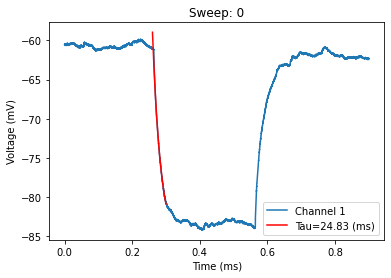

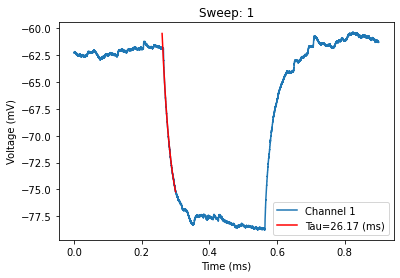

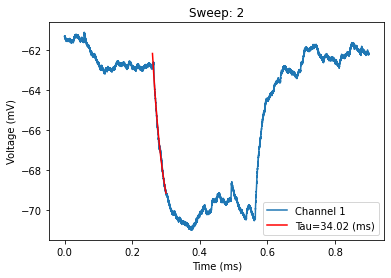

In [314]:
#%% membrane time constant (TAU)

# plot the first channel
start = np.int(0.26 * sr) # ~ 10% to 20% OF OF THE MAXIMUM VOLTAGE DEFLECTION
end = np.int(0.3  * sr) # ADJUST THE NUMBER
pdf_pages_all = PdfPages('Membrane_time_constant_traces.pdf')
tau = [ ]
for i in range (0,3): # the number of sweeps in hyperpolarization steps
    abfIV.setSweep(sweepNumber=i, channel=0)
    fig1 = plt.figure()
    plt.plot(abfIV.sweepX, abfIV.sweepY, label="Channel 1")

    popt, pcov = curve_fit(func_exp_1, abfIV.sweepX[start:end], abfIV.sweepY[start:end], maxfev = 10000)
    
    
    plt.plot(abfIV.sweepX[start:end], func_exp_1(abfIV.sweepX[start:end], *popt), 'r-',
    label='Tau=%5.2f (ms)' % (1e3*popt[1]))
    tau.append(1e3*popt[1])
    
    plt.title('Sweep: %d' %i)
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()
    pdf_pages_all.savefig(fig1)
pdf_pages_all.close()

plt.savefig(os.path.join(save_path , 'Membrane_time_constant_traces.svg'))
plt.savefig(os.path.join(save_path , 'Membrane_time_constant_traces.pdf'))



In [315]:
tau

[24.828430017240557, 26.167152356127808, 34.02490123717994]

In [316]:
#%% Membrane time constant visualization
# choosing the hyperpolarization traces
start_trace = 0
end_trace = len(tau)

fig = px.scatter(x = current_step[start_trace:end_trace],y = tau, labels={'x':'Current (pA)', 'y':'Volatage (mV)'}, 
                 title="I-V Curve")

popt, pcov = curve_fit(func, current_step[start_trace:end_trace], voltage_step[start_trace:end_trace])
popt
fig.add_trace(go.Scatter(x = current_step[start_trace:end_trace], y = [np.mean(tau),np.mean(tau),np.mean(tau)], mode='lines',
    name='tau mean = %.2f' %(np.mean(tau)),
    marker=dict(
        color='rgb(255, 0, 0)')))
fig.show()
fig.write_image(os.path.join(save_path , 'Membrane_time_constant.pdf'))
fig.write_image(os.path.join(save_path , 'Membrane_time_constant.svg'))


In [317]:
#%% Voltage Deflection___VOLTAGE BASE
#Get the voltage base
sr = abfIV.dataRate   # SAMPLING rate in Hz
start = np.int(0.240 * sr) # 10% OF OF THE baseline
end = np.int(0.250  * sr)

voltage_base=[]
for i in range (abfIV.sweepCount):
   abfIV.setSweep(sweepNumber=i, channel=0) # set the baseline based on above figure
   a = np.median(abfIV.sweepY[start:end])
   voltage_base.append(a)
# voltage_base = np.mean(voltage_base)
print(voltage_base)

[-60.668945, -61.706543, -62.77466, -63.049316, -62.072754, -62.194824, -62.683105, -63.720703, -64.0564, -63.14087, -64.36157, -62.164307, -63.949585, -67.90161, -67.93213, -61.950684]


In [318]:
#%% Voltage deflection
sr = abfIV.dataRate   # SAMPLING rate in Hz
start = np.int(0.530 * sr) # 10% OF OF THE baseline
end = np.int(0.564  * sr)
sweepcount = 3
voltage_deflection=[]
for i in range (sweepcount):
   abfIV.setSweep(sweepNumber=i, channel=0) # set the baseline based on above figure
   a = np.median(abfIV.sweepY[start:end])
   voltage_deflection.append(a)
print(voltage_deflection)

[-83.49609, -78.6438, -70.19043]


In [319]:
#%% Sag amplitude 
# NOTE : YOU SHOULD ONLY TAKE TRACES WITH POSITIVE VALUES WHICH MEN THERE IS A SAG AMPLITUDE
sr = abfIV.dataRate   # SAMPLING rate in Hz
start = np.int(0.263 * sr) # 10% OF OF THE baseline
end = np.int(0.300  * sr)
sweepcount = 3

sag_amplitude=[]
for i in range (sweepcount):
    abfIV.setSweep(sweepNumber=i, channel=0) # set the baseline based on above figure
    a = np.min(abfIV.sweepY[start:end])
    sag_amplitude.append(a)
print(sag_amplitude)

[-80.65796, -75.22583, -69.21387]


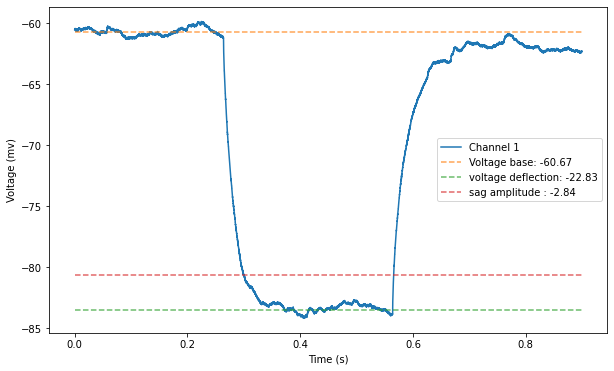

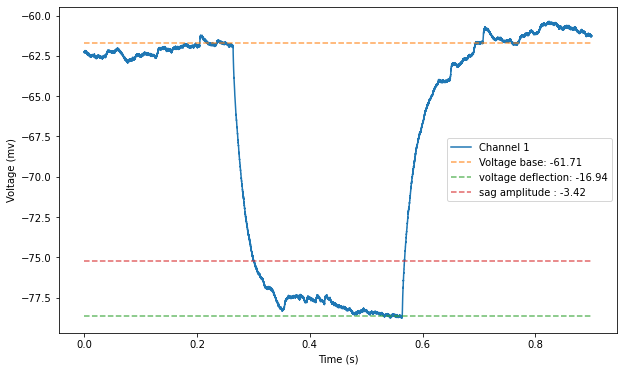

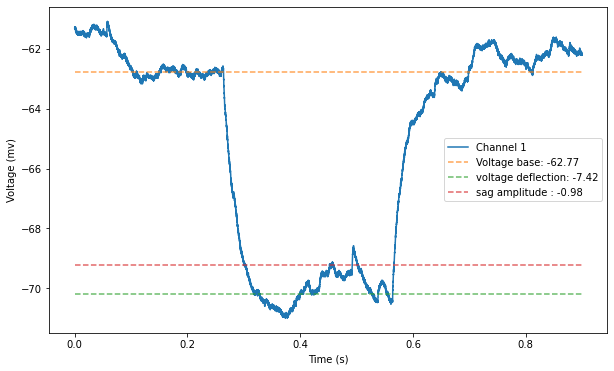

In [320]:
#%% plotting the voltage deflection + voltage base + sag amplitude
pdf_pages_all = PdfPages(os.path.join(save_path, 'Membrane_base_deflection.pdf'))
for i in range (0,3):
    fig, ax = plt.subplots(figsize=(10, 6))
    abfIV.setSweep(sweepNumber=i, channel=0)
    ax.plot(abfIV.sweepX, abfIV.sweepY, label="Channel 1")
    plt.ylabel('Voltage (mv)')
    plt.xlabel('Time (s)')
            
    plt.plot([np.min(abfIV.sweepX), np.max(abfIV.sweepX)], [voltage_base[i] , 
                                                        voltage_base[i]] , ls='--', alpha=0.7, c='C1', 
             label= 'Voltage base: %.2f' % voltage_base[i])

    
    plt.plot([np.min(abfIV.sweepX),np.max(abfIV.sweepX)], [voltage_deflection[i] , 
                                                       voltage_deflection[i]] , ls='--', alpha=0.7, c='C2', 
             label= 'voltage deflection: %.2f' % (voltage_deflection[i]- voltage_base[i]))
    
    plt.plot([np.min(abfIV.sweepX),np.max(abfIV.sweepX)], [sag_amplitude[i] , 
                                                        sag_amplitude[i]] , ls='--', alpha=0.7, c='C3', 
              label= 'sag amplitude : %.2f' % (voltage_deflection[i]- sag_amplitude[i]))

    pdf_pages_all.savefig(fig)
    plt.legend()

pdf_pages_all.close()
plt.savefig(os.path.join(save_path , 'Membrane_base_deflection.svg'))
# plt.savefig(os.path.join(save_path , 'Membrane_base_deflection.pdf'))
sag_amplitudes = np.mean(list(np.array(sag_amplitude) - np.array(voltage_deflection)))



In [321]:
#%% Exporting data to Excell for analysis
tau =np.mean(tau)
writer = pd.ExcelWriter(os.path.join(save_path, 'Passive_membrane_properties_41_46.xlsx'))

pd.DataFrame({'series_resitance (mOhm)': 
              [series_resitance]}).to_excel(writer,sheet_name = 
                                               'Passive_membrane_Test', startcol=0,index=False)
pd.DataFrame({'membrane_resitance_test (mOhm)': 
              [membrane_resitance_test]}).to_excel(writer,sheet_name = 
                                                'Passive_membrane_Test', startcol=1, index=False)
pd.DataFrame({'leak_current (pA)': 
              [leak_current]}).to_excel(writer,sheet_name = 
                                                'Passive_membrane_Test', startcol=2, index=False)
pd.DataFrame({'Whole_Cell_Capacitance (pF)': 
              [Whole_Cell_Capacitance]}).to_excel(writer,sheet_name = 
                                                'Passive_membrane_Test', startcol=3, index=False) 
                                                
                                                

pd.DataFrame({'resting_potential_observed (mV)': 
              [-65]}).to_excel(writer,sheet_name = 
                                               'Passive_membrane_IV', startcol=0,index=False)
pd.DataFrame({'resting_potential (mV)': 
              [resting_potential]}).to_excel(writer,sheet_name = 
                                               'Passive_membrane_IV', startcol=1,index=False)
pd.DataFrame({'membrane_resitance (mOhm)': 
              [membrane_resistance]}).to_excel(writer,sheet_name = 
                                                'Passive_membrane_IV', startcol=2, index=False)
pd.DataFrame({'tau (ms)': 
              [tau]}).to_excel(writer,sheet_name = 
                                                'Passive_membrane_IV', startcol=3, index=False)
pd.DataFrame({'sag_amplitude (mV)': 
              [sag_amplitudes]}).to_excel(writer,sheet_name = 
                                                'Passive_membrane_IV', startcol=4, index=False) 
                                        
writer.save()


